In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
import pickle
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16,preprocess_input
#from keras.preprocessing.image import load_img,img_to_array
from keras.preprocessing import image

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences

from keras.models import Model
from keras.utils import to_categorical,plot_model
from keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Final_project_data/final_project

/content/drive/MyDrive/Final_project_data/final_project


In [ ]:
base_dir="/content/drive/MyDrive/Final_project_data/final_project"
working_dir="/content/drive/MyDrive/Final_project_data/final_project/working_dir"

In [ ]:
model=VGG16()
model=Model(inputs=model.inputs,outputs=model.layers[-2].output)


553467096/553467096 [==============================] - 6s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.save_weights('model_resnet_weights.h5')

In [ ]:
features = {}
directory = os.path.join(base_dir, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
len(features)

8091

In [ ]:
pickle.dump(features, open(os.path.join(working_dir, 'features.pkl'), 'wb'))

In [ ]:
features_path = os.path.join(working_dir, 'features.pkl')
with open(features_path, 'rb') as file:
    features = pickle.load(file)

In [ ]:
with open(os.path.join(base_dir, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
captions_doc

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1002674143_1b742ab4b8.j

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in captions_doc.split('\n'):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

In [ ]:
mapping[list(mapping.keys())[0]]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
len(mapping)

8091

## Preprocess Text Data

In [ ]:
# def clean(mapping):
#   for key,captions in mapping.items():
#     for i in range(len(captions)):
#       caption=captions[i]
#       caption=caption.lower()
#       caption=caption.replace('[^A-Za-z]', '')
#       caption=caption.replace('\s+', ' ')
#       caption='startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
#       caption[i]=caption


In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            #caption = " ".join([word for word in caption.split() if len(word)>1])
            #caption = caption.capitalize()
            captions[i] = caption
            #caption = caption.capitalize()



In [ ]:
#befor preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
#preprocess the text
clean(mapping)

In [ ]:
#after preprocess the text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions=[]
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [ ]:
8091*5

40455

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
#tokenize the text
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1


In [ ]:
vocab_size

8485

In [ ]:
# #tokenize the text
# tokenizer=Tokenizer()
# tokenizer.fit_on_texts(all_captions)
# vocab_size=len(tokenizer.word_index)

In [ ]:
#get maximum length of the caption available
max_length=max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [ ]:
image_ids=list(mapping.keys())
split=int(len(image_ids)* .90)
split

7281

In [ ]:
train=image_ids[:split]
test=image_ids[split:]

In [ ]:
# create data genretor
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model creation

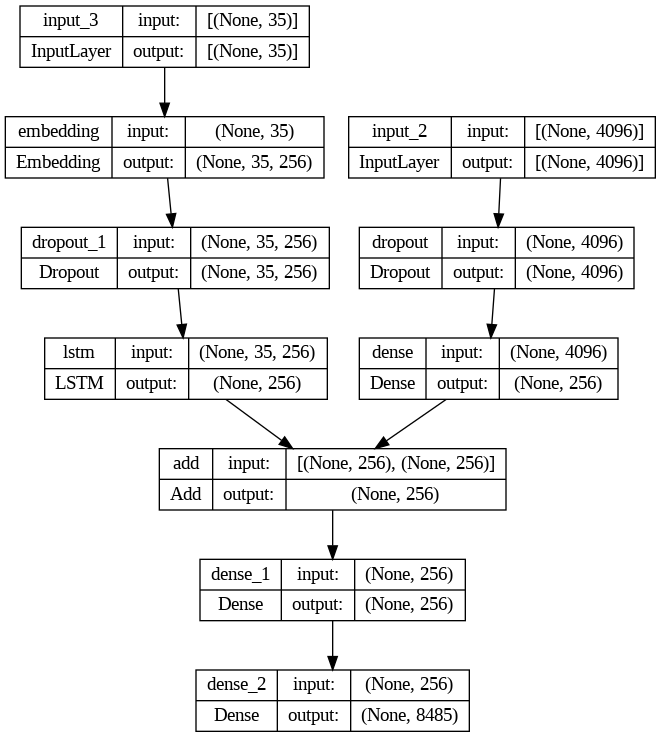

In [ ]:
#encoder model
inputs1=Input(shape=(4096,))
fe1=Dropout(.4)(inputs1)
fe2=Dense(256,activation="relu")(fe1)

#sequence feature layers
inputs2=Input(shape=(max_length,))
se1=Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2=Dropout(0.4)(se1)
se3=LSTM(256)(se2)
#seqeunce feature layers
decoder1=add([fe2,se3])
decoder2=Dense(256,activation="relu")(decoder1)
outputs=Dense(vocab_size,activation="softmax")(decoder2)

model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#plot the model
plot_model(model,show_shapes=True)


In [ ]:
# train the model
epochs = 42
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    #model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 63s 276ms/step - loss: 1.8114 - accuracy: 0.5125


In [ ]:
model.save("best_mode_vgg_40.h5")

In [ ]:
model = keras.models.load_model('best_mode_vgg_40.h5')

In [ ]:
# import pickle
# # saving
# with open('tokenizer40_new.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle)

In [ ]:
import pickle
# saving
with open('tokenizer40.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('tokenizer40.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

## generate cation for image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.540437
BLEU-2: 0.316454


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    image_name = "667626_18933d713e.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(base_dir, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    plt.imshow(image)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')

    print(y_pred)


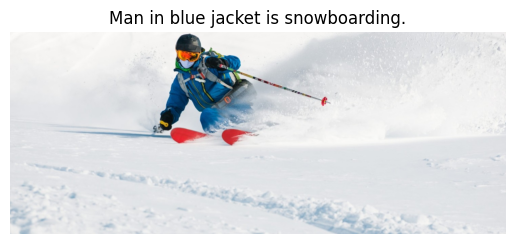

In [ ]:
# generate_caption("3707990914_843e8f15f1.jpg")
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))  # Resize the image to match VGG16 input size
    image = np.array(image)
    image = preprocess_input(image)
    return image

def generate_caption_for_new_image(image_path):
    # Preprocess the image
    new_image = preprocess_image(image_path)

    # Generate features for the new image using the pre-trained VGG16 model
    vgg_model = VGG16()
    vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
    new_image_features = vgg_model.predict(np.array([new_image]), verbose=0)

    # Predict caption for the new image
    predicted_caption = predict_caption(model, new_image_features, tokenizer, max_length)  #loaded_model, new_image_features, loaded_tokenizer,

    # Remove startseq and endseq tokens
    predicted_caption = predicted_caption.replace('startseq', '').replace('endseq', '').strip()

    # Capitalize the first letter
    predicted_caption = predicted_caption.capitalize()

    # Add a full stop at the end if not present
    if not predicted_caption.endswith('.'):
        predicted_caption += '.'

    # Display the image and the predicted caption
    plt.imshow(Image.open(image_path))
    plt.title(predicted_caption)
    plt.axis('off')
    plt.show()
# Specify the path to the new image
new_image_path = "/content/drive/MyDrive/d89abf6bfc3f652c5e3ff50294259853abbb348ad95afca77fc5a200.jpg"
generate_caption_for_new_image(new_image_path)

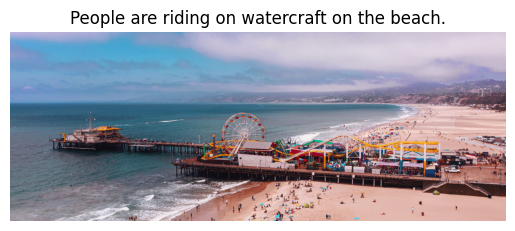

In [ ]:
# generate_caption("3707990914_843e8f15f1.jpg")
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))  # Resize the image to match VGG16 input size
    image = np.array(image)
    image = preprocess_input(image)
    return image

def generate_caption_for_new_image(image_path):
    # Preprocess the image
    new_image = preprocess_image(image_path)

    # Generate features for the new image using the pre-trained VGG16 model
    vgg_model = VGG16()
    vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
    new_image_features = vgg_model.predict(np.array([new_image]), verbose=0)

    # Predict caption for the new image
    predicted_caption = predict_caption(model, new_image_features, tokenizer, max_length)  #loaded_model, new_image_features, loaded_tokenizer,

    # Remove startseq and endseq tokens
    predicted_caption = predicted_caption.replace('startseq', '').replace('endseq', '').strip()

    # Capitalize the first letter
    predicted_caption = predicted_caption.capitalize()

    # Add a full stop at the end if not present
    if not predicted_caption.endswith('.'):
        predicted_caption += '.'

    # Display the image and the predicted caption
    plt.imshow(Image.open(image_path))
    plt.title(predicted_caption)
    plt.axis('off')
    plt.show()
# Specify the path to the new image
new_image_path = "/content/drive/MyDrive/image.jpg"
generate_caption_for_new_image(new_image_path)

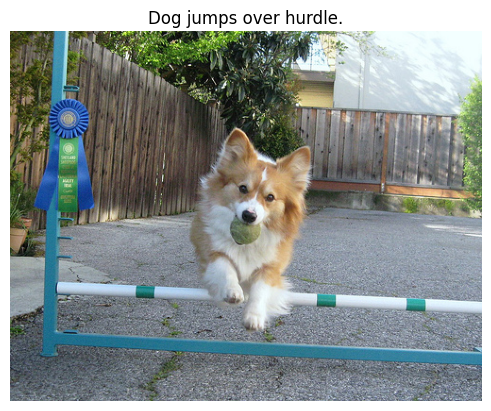

In [ ]:
# generate_caption("3707990914_843e8f15f1.jpg")
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))  # Resize the image to match VGG16 input size
    image = np.array(image)
    image = preprocess_input(image)
    return image

def generate_caption_for_new_image(image_path):
    # Preprocess the image
    new_image = preprocess_image(image_path)

    # Generate features for the new image using the pre-trained VGG16 model
    vgg_model = VGG16()
    vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
    new_image_features = vgg_model.predict(np.array([new_image]), verbose=0)

    # Predict caption for the new image
    predicted_caption = predict_caption(model, new_image_features, tokenizer, max_length)  #loaded_model, new_image_features, loaded_tokenizer,

    # Remove startseq and endseq tokens
    predicted_caption = predicted_caption.replace('startseq', '').replace('endseq', '').strip()

    # Capitalize the first letter
    predicted_caption = predicted_caption.capitalize()

    # Add a full stop at the end if not present
    if not predicted_caption.endswith('.'):
        predicted_caption += '.'

    # Display the image and the predicted caption
    plt.imshow(Image.open(image_path))
    plt.title(predicted_caption)
    plt.axis('off')
    plt.show()
# Specify the path to the new image
new_image_path = "/content/drive/MyDrive/3384314832_dffc944152.jpg"
generate_caption_for_new_image(new_image_path)

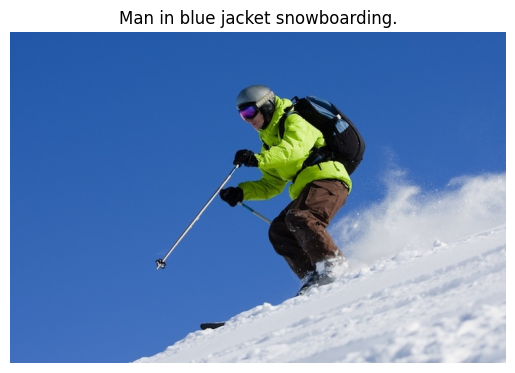

In [ ]:
# generate_caption("3707990914_843e8f15f1.jpg")
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))  # Resize the image to match VGG16 input size
    image = np.array(image)
    image = preprocess_input(image)
    return image

def generate_caption_for_new_image(image_path):
    # Preprocess the image
    new_image = preprocess_image(image_path)

    # Generate features for the new image using the pre-trained VGG16 model
    vgg_model = VGG16()
    vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
    new_image_features = vgg_model.predict(np.array([new_image]), verbose=0)

    # Predict caption for the new image
    predicted_caption = predict_caption(model, new_image_features, tokenizer, max_length)  #loaded_model, new_image_features, loaded_tokenizer,

    # Remove startseq and endseq tokens
    predicted_caption = predicted_caption.replace('startseq', '').replace('endseq', '').strip()

    # Capitalize the first letter
    predicted_caption = predicted_caption.capitalize()

    # Add a full stop at the end if not present
    if not predicted_caption.endswith('.'):
        predicted_caption += '.'

    # Display the image and the predicted caption
    plt.imshow(Image.open(image_path))
    plt.title(predicted_caption)
    plt.axis('off')
    plt.show()
# Specify the path to the new image
new_image_path = "/content/drive/MyDrive/961b377b96dbf7cbe2729e0552d2bd7e720c7bc16bf761fd7b53efeb.jpg"
generate_caption_for_new_image(new_image_path)

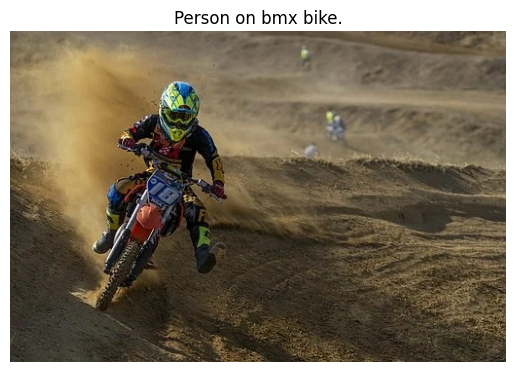

In [ ]:
# generate_caption("3707990914_843e8f15f1.jpg")
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))  # Resize the image to match VGG16 input size
    image = np.array(image)
    image = preprocess_input(image)
    return image

def generate_caption_for_new_image(image_path):
    # Preprocess the image
    new_image = preprocess_image(image_path)

    # Generate features for the new image using the pre-trained VGG16 model
    vgg_model = VGG16()
    vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
    new_image_features = vgg_model.predict(np.array([new_image]), verbose=0)

    # Predict caption for the new image
    predicted_caption = predict_caption(model, new_image_features, tokenizer, max_length)  #loaded_model, new_image_features, loaded_tokenizer,

    # Remove startseq and endseq tokens
    predicted_caption = predicted_caption.replace('startseq', '').replace('endseq', '').strip()

    # Capitalize the first letter
    predicted_caption = predicted_caption.capitalize()

    # Add a full stop at the end if not present
    if not predicted_caption.endswith('.'):
        predicted_caption += '.'

    # Display the image and the predicted caption
    plt.imshow(Image.open(image_path))
    plt.title(predicted_caption)
    plt.axis('off')
    plt.show()
# Specify the path to the new image
new_image_path = "/content/drive/MyDrive/70cf5ab3538f1eb82c96313a7983be80e95988cc9d1dab4b5a5aa51e.jpeg"
generate_caption_for_new_image(new_image_path)

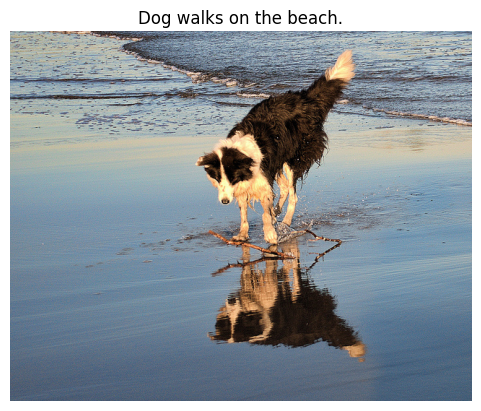

In [ ]:
# generate_caption("3707990914_843e8f15f1.jpg")
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))  # Resize the image to match VGG16 input size
    image = np.array(image)
    image = preprocess_input(image)
    return image

def generate_caption_for_new_image(image_path):
    # Preprocess the image
    new_image = preprocess_image(image_path)

    # Generate features for the new image using the pre-trained VGG16 model
    vgg_model = VGG16()
    vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
    new_image_features = vgg_model.predict(np.array([new_image]), verbose=0)

    # Predict caption for the new image
    predicted_caption = predict_caption(model, new_image_features, tokenizer, max_length)  #loaded_model, new_image_features, loaded_tokenizer,

    # Remove startseq and endseq tokens
    predicted_caption = predicted_caption.replace('startseq', '').replace('endseq', '').strip()

    # Capitalize the first letter
    predicted_caption = predicted_caption.capitalize()

    # Add a full stop at the end if not present
    if not predicted_caption.endswith('.'):
        predicted_caption += '.'

    # Display the image and the predicted caption
    plt.imshow(Image.open(image_path))
    plt.title(predicted_caption)
    plt.axis('off')
    plt.show()
# Specify the path to the new image
new_image_path = "/content/drive/MyDrive/dog.jpg"
generate_caption_for_new_image(new_image_path)

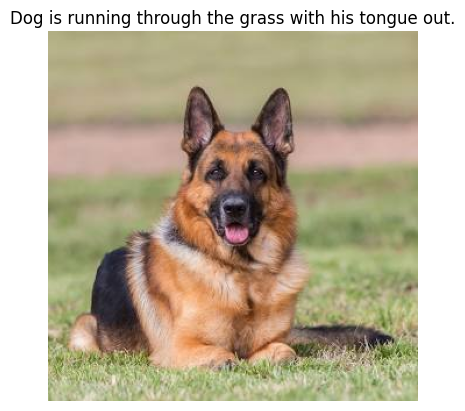

In [ ]:
# generate_caption("3707990914_843e8f15f1.jpg")
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))  # Resize the image to match VGG16 input size
    image = np.array(image)
    image = preprocess_input(image)
    return image

def generate_caption_for_new_image(image_path):
    # Preprocess the image
    new_image = preprocess_image(image_path)

    # Generate features for the new image using the pre-trained VGG16 model
    vgg_model = VGG16()
    vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
    new_image_features = vgg_model.predict(np.array([new_image]), verbose=0)

    # Predict caption for the new image
    predicted_caption = predict_caption(model, new_image_features, tokenizer, max_length)  #loaded_model, new_image_features, loaded_tokenizer,

    # Remove startseq and endseq tokens
    predicted_caption = predicted_caption.replace('startseq', '').replace('endseq', '').strip()

    # Capitalize the first letter
    predicted_caption = predicted_caption.capitalize()

    # Add a full stop at the end if not present
    if not predicted_caption.endswith('.'):
        predicted_caption += '.'

    # Display the image and the predicted caption
    plt.imshow(Image.open(image_path))
    plt.title(predicted_caption)
    plt.axis('off')
    plt.show()
# Specify the path to the new image
new_image_path = "/content/drive/MyDrive/download.jpg"
generate_caption_for_new_image(new_image_path)

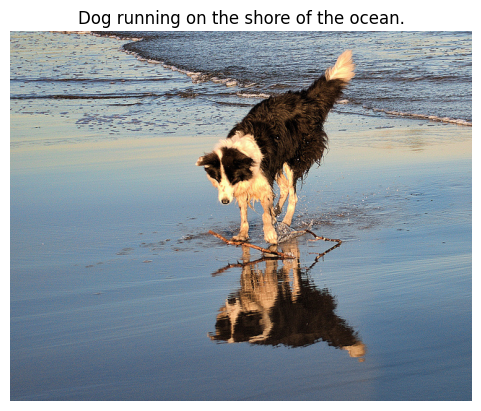

In [ ]:
# generate_caption("3707990914_843e8f15f1.jpg")
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))  # Resize the image to match VGG16 input size
    image = np.array(image)
    image = preprocess_input(image)
    return image

def generate_caption_for_new_image(image_path):
    # Preprocess the image
    new_image = preprocess_image(image_path)

    # Generate features for the new image using the pre-trained VGG16 model
    vgg_model = VGG16()
    vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
    new_image_features = vgg_model.predict(np.array([new_image]), verbose=0)

    # Predict caption for the new image
    predicted_caption = predict_caption(model, new_image_features, tokenizer, max_length)  #loaded_model, new_image_features, loaded_tokenizer,

    # Remove startseq and endseq tokens
    predicted_caption = predicted_caption.replace('startseq', '').replace('endseq', '').strip()

    # Capitalize the first letter
    predicted_caption = predicted_caption.capitalize()

    # Add a full stop at the end if not present
    if not predicted_caption.endswith('.'):
        predicted_caption += '.'

    # Display the image and the predicted caption
    plt.imshow(Image.open(image_path))
    plt.title(predicted_caption)
    plt.axis('off')
    plt.show()
# Specify the path to the new image
new_image_path = "/content/drive/MyDrive/dog.jpg"
generate_caption_for_new_image(new_image_path)